In [114]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2
Today date is:  2024-06-12


In [115]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 14988
drwxrwxr-x 1 1000 1000     598 Jun 12 15:29 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
-rw------- 1 1000 1000 1449984 Jun  4 00:49 20240601.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  3 23:44 20240602.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun  4 16:45 20240603.mktdata.ohlcv.db
-rw------- 1 1000 1000 1269760 Jun  5 10:00 20240604.mktdata.ohlcv.db
-rw------- 1 1000 1000 1081344 Jun  6 10:00 20240605.mktdata.ohlcv.db
-rw------- 1 1000 1000 1441792 Jun  7 10:00 20240606.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  8 10:00 20240607.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun  9 10:00 20240608.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun 10 10:00 20240609.mktdata.ohlcv.db
-rw-r--r-- 1 1000 1000       0 Jun 12 15:29 20240609.mktdata.ohlcvdb
-rw------- 1 1000 1000 1437696 Jun 11 10:00 20240610.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun 12 10:01 20240611.mktdata.ohlcv.db


In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [128]:
directory = "/workspace/data/crypto_md"

# List of dates
dates = ['20240601', 
         '20240602', 
         '20240603', 
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608', 
         '20240609',
         '20240610']
         
# '20240601', '20240602', '20240601', '20240602'

# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    
    # Print the combined DataFrame
    print(df_concat.shape[0])
    # print(df_concat.shape[1])

    conn.close()

print(df_concat.head(2))
print(df_concat.tail(2))

5759
11519
17213
22272
26556
32316
38076
43836
49596
55283
                tstamp exchange_id instrument_id      open      high  \
0  1717200000000000000    COINBASE  PAIR-BTC-USD  67473.07  67514.99   
1  1717200060000000000    COINBASE  PAIR-BTC-USD  67506.57  67515.00   

        low     close    volume          vwap  
0  67468.13  67506.03  2.045049  67496.869352  
1  67480.66  67494.74  0.646759  67500.893305  
                    tstamp exchange_id instrument_id    open    high     low  \
55281  1718063880000000000    COINBASE  PAIR-XRP-USD  0.4968  0.4968  0.4966   
55282  1718063940000000000    COINBASE  PAIR-XRP-USD  0.4967  0.4967  0.4966   

        close       volume      vwap  
55281  0.4967  9143.928579  0.496704  
55282  0.4967  3314.651869  0.496681  


In [129]:
df_concat['tstamp'] = pd.to_datetime(df_concat['tstamp'])
# Extract individual components
df_concat['year'] = df_concat['tstamp'].dt.year
df_concat['month'] = df_concat['tstamp'].dt.month
df_concat['day'] = df_concat['tstamp'].dt.day
df_concat['hour'] = df_concat['tstamp'].dt.hour
df_concat['minute'] = df_concat['tstamp'].dt.minute
df_concat['second'] = df_concat['tstamp'].dt.second

df_concat['date'] = df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

In [130]:
print(df_concat.head())
# print(df_concat.tail(2))

       date instrument_id       close        volume          vwap
0     1-0-0  PAIR-BTC-USD  67506.0300      2.045049  67496.869352
1440  1-0-0  PAIR-ETH-USD   3762.0400     37.497964   3761.077765
2880  1-0-0  PAIR-LTC-USD     83.1700    110.056253     83.166206
4319  1-0-0  PAIR-XRP-USD      0.5173  28809.165339      0.517217
1     1-0-1  PAIR-BTC-USD  67494.7400      0.646759  67500.893305


In [120]:
instrument_list = df_concat['instrument_id'].unique().tolist()
print("Distinct values in column 'instrument_id':", instrument_list)

Distinct values in column 'instrument_id': ['PAIR-BTC-USD', 'PAIR-ETH-USD', 'PAIR-LTC-USD', 'PAIR-XRP-USD']


In [136]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_BTC'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_BTC'] = df_concat_btc['volume']
df_concat_btc['vwap_BTC'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

print (df_concat_btc.head(3))

    date  close_BTC  volume_BTC  vwap_BTC
0  1-0-0   0.675060    2.045049  0.674969
1  1-0-1   0.674947    0.646759  0.675009
2  1-0-2   0.675150    9.732906  0.674778


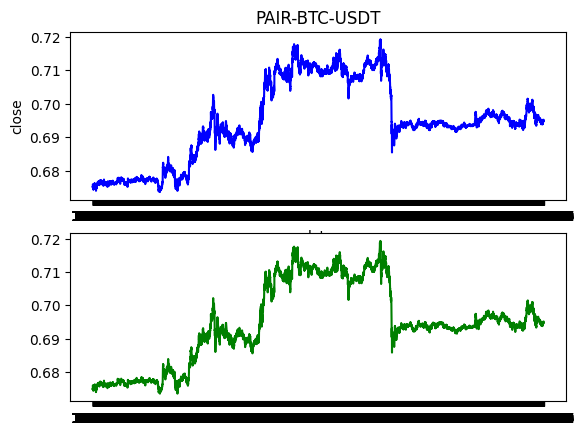

In [140]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_BTC'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_BTC'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_BTC'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()